In [1]:
#Include the UNSflow libraries
#Pkg.clone("git://github.com/KiranUofG/UNSflow")
include("../src/UNSflow.jl")
using UNSflow

### This notebook is related to the topic of modelling separated flows by modifying formulas for forces and moments.

### All of the cases are steady-state. ldvm_klb solver is used, which does not model unsteady separation point position. If unsteady separation point position is sought, use ldvm_klb_tr solver.

### Since separation point location is dependent on Reynolds number, cases that base on static constants derived from data from Xfoil will be validated by data from Xfoil. Similarly with experimental data.

#### Case 0.

0.1. Convergence.

0.2. Test of different formulas for moment coefficient and chord force coefficient.

0.3. Discussion whether fsep should be based on angle of attack or effective angle of attack.


#### Case 1. SD7003 aerofoil
1.1. Xfoil

1.2. Exp. [1]


#### Case 2. NACA 0012 aerofoil
2.1. Xfoil

2.2. Exp. [2]

2.3. Exp. [3]

#### Case 3. NACA 0015 aerofoil
3.1. Xfoil

 
[1] Selig, M.S., Lyon, C.A., Giguère, P., Ninham, C.N., and Guglielmo, J.J., Summary of Low-Speed Airfoil Data, Vol. 2, SoarTech Publications, Virginia Beach, VA, 1996, 252 pages. Wind tunnel data on 25 airfoils tested at Reynolds Numbers ranging from 40,000 to 400,000. Available at: http://m-selig.ae.illinois.edu/uiuc_lsat/Low-Speed-Airfoil-Data-V2.pdf

[2] https://turbmodels.larc.nasa.gov/NACA0012_validation/CLCD_Ladson_expdata.dat, 05.07.2017

[3]  McAlister, Kenneth W., Lawrence W. Carr, and William J. McCroskey. "Dynamic stall experiments on the NACA 0012 airfoil." (1978). https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19780009057.pdf

## 0.1 Convergence

Function SeparationParams collects all static constants and models chosen. Neccessary parameters are alpha1, s1, s2 and model (Sheng or Original). Other parameters are set by default to the best working and can be changed using keyword parameters.

This case compares convergence rates between solvers that base separation point location on angle of attack and effective angle of attack for three values of alpha: 0, 10 and 20 deg.

Expected results:

a) For alpha=0 deg both lift coefficients should quickly reach value of 0.

b) For alpha=10 deg convergence should be slower.

c) For alpha=20 deg (above stall angle) oscillations in lift coefficient should appear.

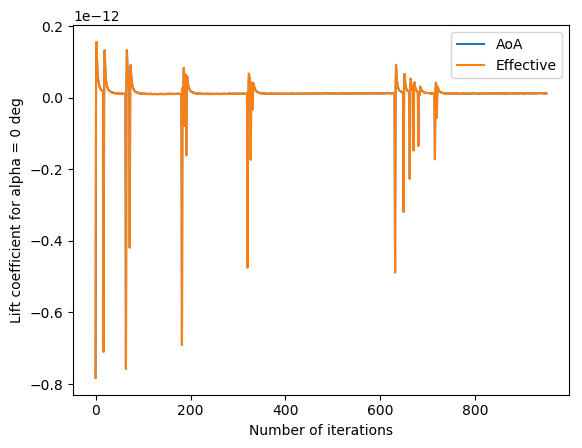

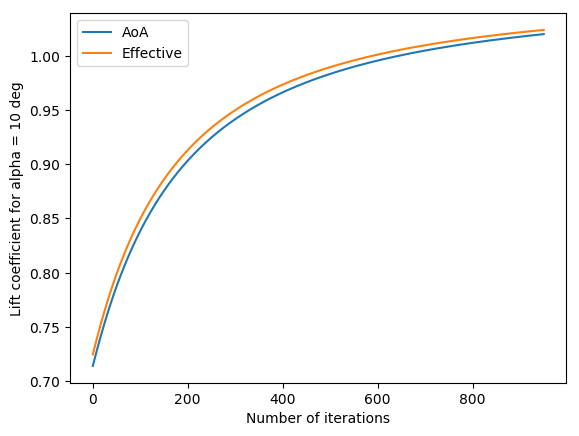

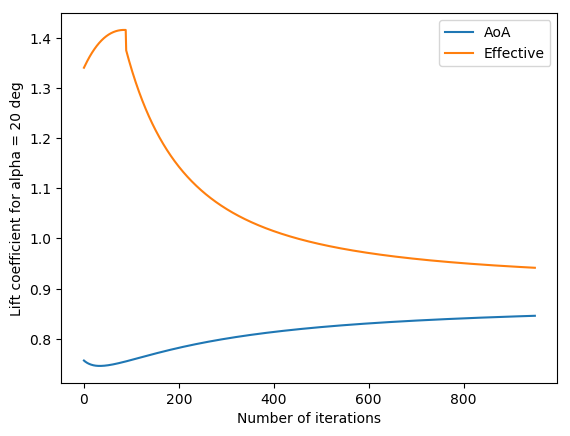

PyObject <matplotlib.legend.Legend object at 0x7f42ffb14b38>

In [2]:
#sepdef = SeparationParams(alpha1,s1,s2,model)
sepdef1 = SeparationParams(15.2, 3.0, 2.3,"Original";aoa = "AoA")
sepdef2 = SeparationParams(15.2, 3.0, 2.3,"Original")
sepdef = [sepdef1 sepdef2]

nsteps = 1000
aseq = [1 11 21]
no_of_cases = length(sepdef)

mat_case = zeros(nsteps,9,3,no_of_cases)

for k = 1 : no_of_cases
no = 1
        for iter = aseq

            alphadef = ConstDef((iter-1)*pi/180)
            hdef = ConstDef(0.)
            udef = ConstDef(1.)#Freestream velocity is a constant. Set as constant = 1

            #The full kinematics are collected as:
            full_kinem = KinemDef(alphadef, hdef, udef)

            pvt = 0.25
            lespcrit = [5.;] #Note that the value is entered as an array. 

            # The argument "FlatPlate" provides zero camber. To use an airfoil, specify the coordinate file which should be
            #in the same folder. For eg. "sd7003.dat". 
            #The XFOIL convention must be used for the coordinate: TE->Upper surface->LE->Lower surface->TE
            surf = TwoDSurf("n0012.dat", pvt, full_kinem,lespcrit)

            curfield = TwoDFlowField()
            #Specify simulation details - time step, and number of steps.
            #The default nondimensional timestep is 0.015. There is usually no need to change this. 

            #Now the code is run as :
            #The variables mat, surf and curfield are returned
            dtstar = 0.015
        
            mat, surf, curfield = ldvm_klb(surf, curfield,sepdef[k], nsteps, dtstar)
            mat_case[:,:,no, k]=mat    
            no = no+1
        end
end 

for case =1:no_of_cases
    label = sepdef[case].aoa
    plot(mat_case[50:end,6,1,case], label="$label")
end
xlabel("Number of iterations")
ylabel("Lift coefficient for alpha = 0 deg")
legend()

figure()
for case =1:no_of_cases
    label = sepdef[case].aoa
    plot(mat_case[50:end,6,2,case], label="$label")
end
xlabel("Number of iterations")
ylabel("Lift coefficient for alpha = 10 deg")
legend()

figure()
for case =1:no_of_cases
    label = sepdef[case].aoa
    plot(mat_case[50:end,6,3,case], label="$label")
end
xlabel("Number of iterations")
ylabel("Lift coefficient for alpha = 20 deg")
legend()

For alpha = 0 deg results are as expected. Solution quickly converges to the correct result.

For alpha = 10 deg solution converges quite slow. However, 700 timesteps should be enough to limit uncertainty related to convergence down to 0.05. Converged values are different between two solvers because in general effective angle of attack < angle of attack.

For alpha = 20 deg suprisingly there are no oscillations. Perhaps oscillations exist only when LEV are shed (or SPV - Separation Point Vortices, as it will be shown in notebooks 3.X). Again, 700 timesteps seem to be enough to limit uncertainty caused by convergence down to 0.05.

## 0.2. Test of different formulas for moment coefficient and chord force coefficient.

Tested formulas for moment coefficient: Dymore, Liu

Tested formulas for suction force coefficient: continuous, piecewise, Sheng_continuous, Sheng_piecewise

Details of all the formulas are presented in report.

In [3]:
sepdef1 = SeparationParams(15.2, 3.0, 2.3,"Original";cm_model = "Dymore", cs_model = "continuous")
sepdef2 =SeparationParams(15.2, 3.0, 2.3,"Original"; cm_model = "Liu", cs_model = "piecewise")
sepdef3 = SeparationParams(15.2, 3.0, 2.3,"Original";cm_model = "Liu", cs_model = "Sheng_continuous")
sepdef4 = SeparationParams(15.2, 3.0, 2.3,"Original";cm_model = "Liu", cs_model = "Sheng_piecewise")

sepdef = [sepdef1 sepdef2 sepdef3 sepdef4]

1×4 Array{UNSflow.SeparationParams,2}:
 UNSflow.SeparationParams(15.2,3.0,2.3,"Original","Effective",0.0,-0.135,0.04,2.0,"Dymore","continuous",3.0,0.12,-1.0,false)  …  UNSflow.SeparationParams(15.2,3.0,2.3,"Original","Effective",0.0,-0.135,0.04,2.0,"Liu","Sheng_piecewise",3.0,0.12,-1.0,false)

In [4]:
nsteps = 700

no_of_cases = length(sepdef)
aseq = [0 3 6 9 12 13 14 15 16 17 18 19 20]
mat_case = zeros(nsteps,9,length(aseq),no_of_cases)

for k = 1 : no_of_cases

        for iter = 1:length(aseq)

            alphadef = ConstDef(aseq[iter]*pi/180)
            hdef = ConstDef(0.)
            udef = ConstDef(1.)#Freestream velocity is a constant. Set as constant = 1

            #The full kinematics are collected as:
            full_kinem = KinemDef(alphadef, hdef, udef)

            pvt = 0.25
            lespcrit = [5.;] #Note that the value is entered as an array. 

            # The argument "FlatPlate" provides zero camber. To use an airfoil, specify the coordinate file which should be
            #in the same folder. For eg. "sd7003.dat". 
            #The XFOIL convention must be used for the coordinate: TE->Upper surface->LE->Lower surface->TE
            surf = TwoDSurf("n0012.dat", pvt, full_kinem,lespcrit)

            curfield = TwoDFlowField()
            #Specify simulation details - time step, and number of steps.
            #The default nondimensional timestep is 0.015. There is usually no need to change this. 

            #Now the code is run as :
            #The variables mat, surf and curfield are returned
            dtstar = 0.015
        
            mat, surf, curfield = ldvm_klb(surf, curfield,sepdef[k], nsteps, dtstar)
            mat_case[:,:,iter, k]=mat        
        end
end 

#LDVM for comparison

mat_ldvm = zeros(nsteps, 10,length(aseq))
  for iter = 1:length(aseq)

            alphadef = ConstDef(aseq[iter]*pi/180)
            hdef = ConstDef(0.)
            udef = ConstDef(1.)#Freestream velocity is a constant. Set as constant = 1

            #The full kinematics are collected as:
            full_kinem = KinemDef(alphadef, hdef, udef)

            pvt = 0.25
            lespcrit = [5.;] #Note that the value is entered as an array. 

            # The argument "FlatPlate" provides zero camber. To use an airfoil, specify the coordinate file which should be
            #in the same folder. For eg. "sd7003.dat". 
            #The XFOIL convention must be used for the coordinate: TE->Upper surface->LE->Lower surface->TE
            surf = TwoDSurf("n0012.dat", pvt, full_kinem,lespcrit)

            curfield = TwoDFlowField()
            #Specify simulation details - time step, and number of steps.
            #The default nondimensional timestep is 0.015. There is usually no need to change this. 

            #Now the code is run as :
            #The variables mat, surf and curfield are returned
            dtstar = 0.015
        
            mat, surf, curfield = ldvm(surf, curfield,nsteps, dtstar)
            mat_ldvm[:,:,iter]=mat
end

In [5]:
# Load data from Xfoil
xfoil = Xfoil("xfoil_0012_CN.txt");

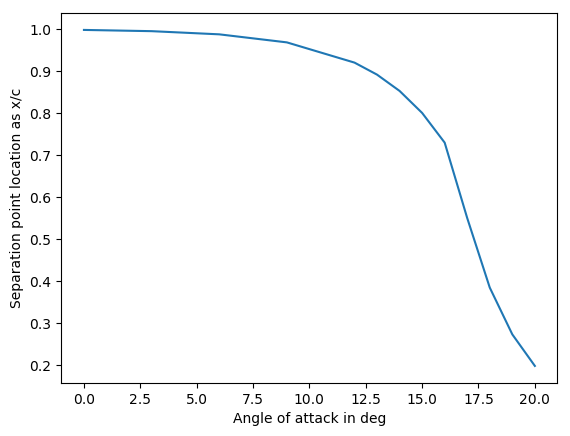

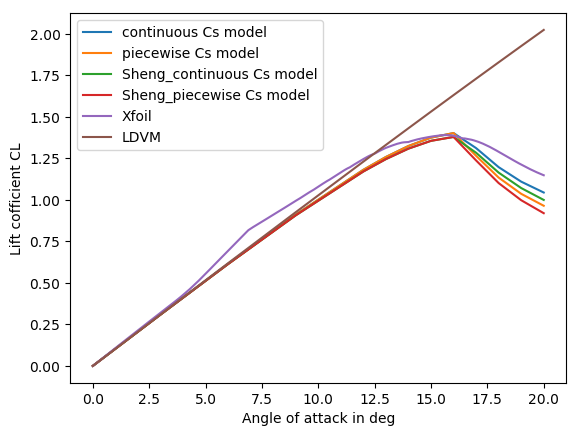

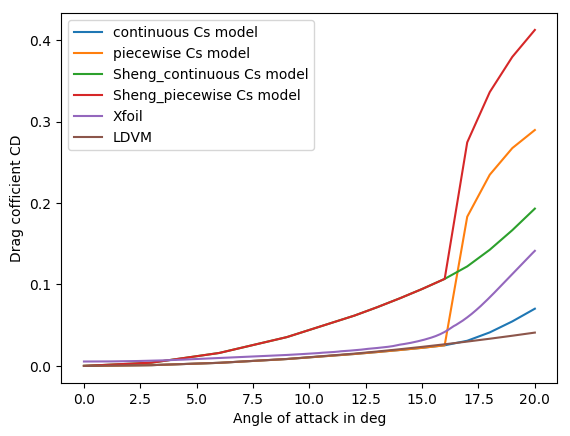

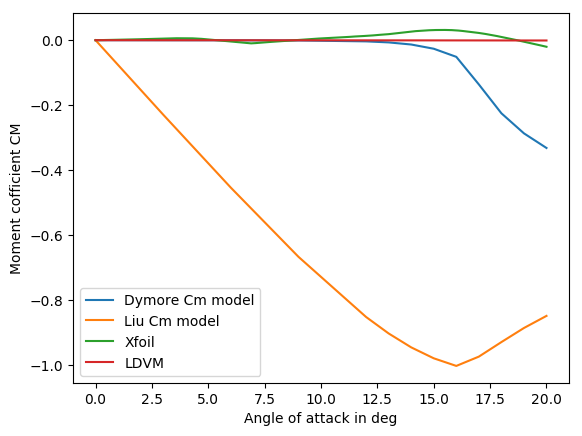

PyObject <matplotlib.legend.Legend object at 0x7f42fbd77908>

In [6]:
# Compare forces and moment coefficients

# Separation point location
plot(mat_case[end,2,:,1]*180./pi,mat_case[end,9,:,1])
xlabel("Angle of attack in deg")
ylabel("Separation point location as x/c")

#LIFT COEFFICIENT
figure()
for case =1:no_of_cases
    label = sepdef[case].cs_model
    plot(mat_case[end,2,:,case]*180./pi,mat_case[end,6,:,case], label="$label Cs model")
end
plot(xfoil.alpha, xfoil.CL, label="Xfoil")
plot(mat_ldvm[end,2,:].*180./pi,mat_ldvm[end,6,:], label="LDVM")
xlabel("Angle of attack in deg")
ylabel("Lift cofficient CL")
legend()

#DRAG COEFFICIENT
figure()
for case= 1:no_of_cases
    label = sepdef[case].cs_model
    plot(mat_case[end,2,:,case]*180./pi,mat_case[end,7,:,case], label="$label Cs model")
end
plot(xfoil.alpha, xfoil.CD, label="Xfoil")
plot(mat_ldvm[end,2,:].*180./pi,mat_ldvm[end,7,:], label="LDVM")
xlabel("Angle of attack in deg")
ylabel("Drag cofficient CD")
legend()

#DRAG COEFFICIENT
figure()
for case= 1:2
    label = sepdef[case].cm_model
    plot(mat_case[end,2,:,case]*180./pi,mat_case[end,8,:,case], label="$label Cm model")
end
plot(xfoil.alpha, xfoil.CM, label="Xfoil")
plot(mat_ldvm[end,2,:].*180./pi,mat_ldvm[end,8,:], label="LDVM")
xlabel("Angle of attack in deg")
ylabel("Moment cofficient CM")
legend()

* Sheng Cs model overpredicts drag coefficient, but it may be a better fit for different aerofoils.

* Continuous Cs model does not result in a sudden growth of CD after passing stall angle. For this aerofoil Xfoil does not predict it either. However, this phenomena is visible for other aerofoils.

* Liu Cm model gives completely unrealistic results. Moment coefficient reaches large values even at low angles of attack. What is more, moment coefficient decreases after passing stall angle.

* Dymore Cm model seems to give realistic results. Moment coefficient is close to 0 at low angles of attack and it increases after passing stall angle, as it is described in literature. Xfoil does not model this phenomena.

Expected
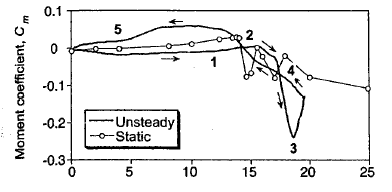

Dymore's manual
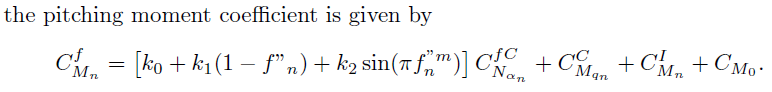

Comparison of formulas
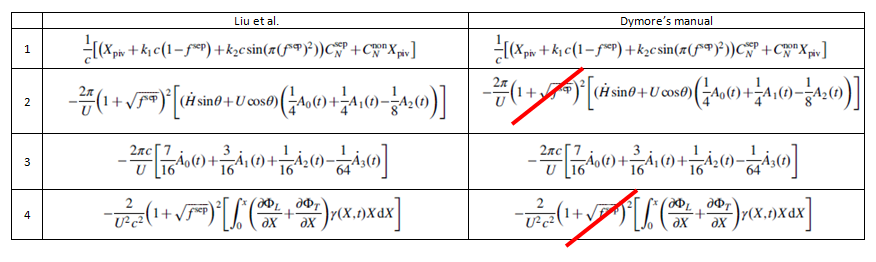

## 0.3. Discussion whether fsep should be based on angle of attack or effective angle of attack.

As presented in the figure below, effective angle of attack is always lower than angle of attack because of velocities induced by trailing-edge vortices.

The question is which approach would give better results.

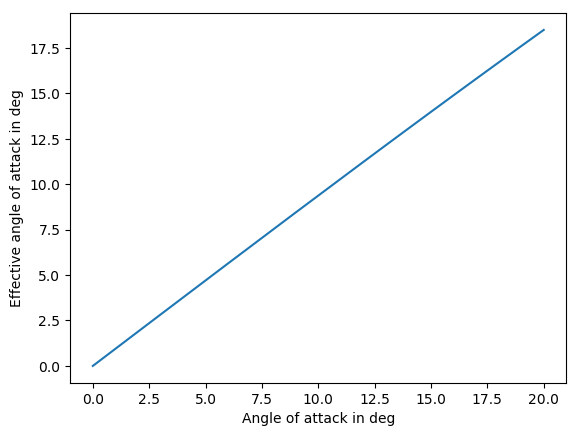

PyObject <matplotlib.text.Text object at 0x7f42fc01c978>

In [7]:
plot(mat_case[end,2,:,1]*180./pi,mat_case[end,5,:,1]*180./pi)
xlabel("Angle of attack in deg")
ylabel("Effective angle of attack in deg")

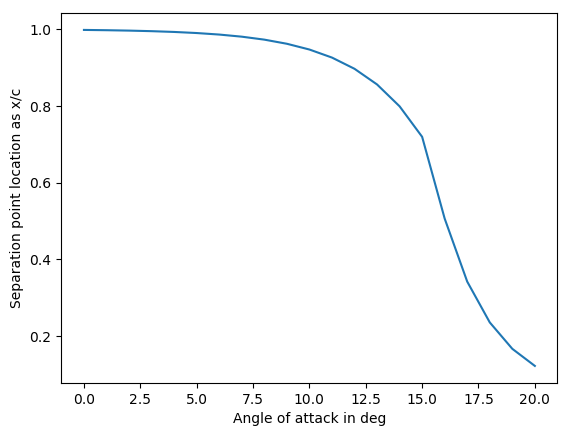

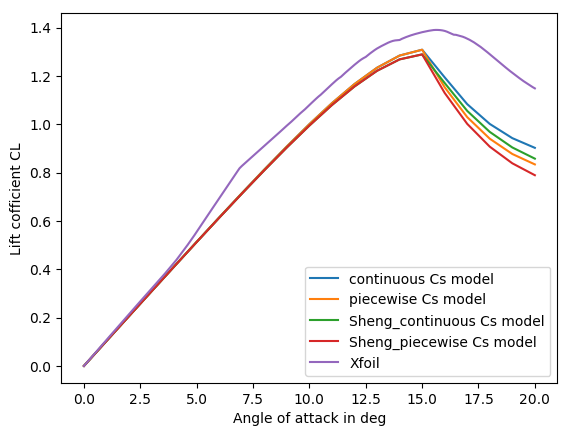

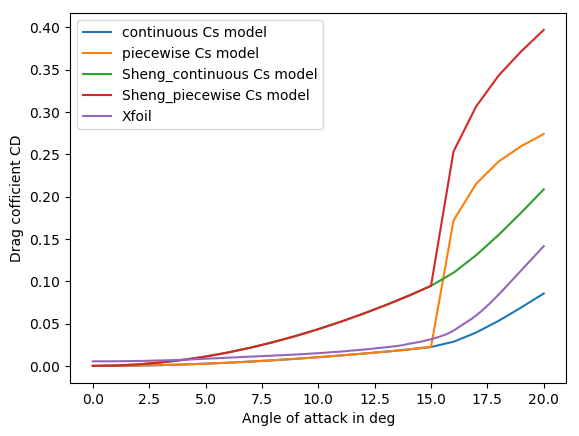

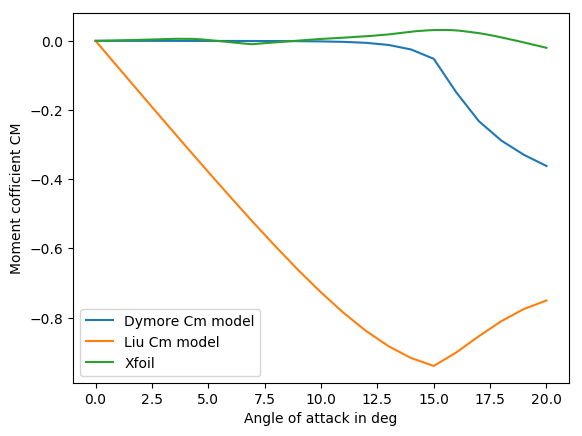

PyObject <matplotlib.legend.Legend object at 0x7f42fbadf7b8>

In [8]:
sepdef1 = SeparationParams(15.2, 3.0, 2.3,"Original";aoa = "AoA", cm_model = "Dymore", cs_model = "continuous")
sepdef2 =SeparationParams(15.2, 3.0, 2.3,"Original";aoa = "AoA", cm_model = "Liu", cs_model = "piecewise")
sepdef3 = SeparationParams(15.2, 3.0, 2.3,"Original";aoa = "AoA",cm_model = "Liu", cs_model = "Sheng_continuous")
sepdef4 = SeparationParams(15.2, 3.0, 2.3,"Original";aoa = "AoA", cm_model = "Liu", cs_model = "Sheng_piecewise")

sepdef = [sepdef1 sepdef2 sepdef3 sepdef4]

nsteps = 700
alphamax = 20
no_of_cases = length(sepdef)

mat_case = zeros(nsteps,9,alphamax+1,no_of_cases)

for k = 1 : no_of_cases

        for iter = 1:alphamax+1

            alphadef = ConstDef((iter-1)*pi/180)
            hdef = ConstDef(0.)
            udef = ConstDef(1.)#Freestream velocity is a constant. Set as constant = 1

            #The full kinematics are collected as:
            full_kinem = KinemDef(alphadef, hdef, udef)

            pvt = 0.25
            lespcrit = [5.;] #Note that the value is entered as an array. 

            # The argument "FlatPlate" provides zero camber. To use an airfoil, specify the coordinate file which should be
            #in the same folder. For eg. "sd7003.dat". 
            #The XFOIL convention must be used for the coordinate: TE->Upper surface->LE->Lower surface->TE
            surf = TwoDSurf("n0012.dat", pvt, full_kinem,lespcrit)

            curfield = TwoDFlowField()
            #Specify simulation details - time step, and number of steps.
            #The default nondimensional timestep is 0.015. There is usually no need to change this. 

            #Now the code is run as :
            #The variables mat, surf and curfield are returned
            dtstar = 0.015
        
            mat, surf, curfield = ldvm_klb(surf, curfield,sepdef[k], nsteps, dtstar)
            mat_case[:,:,iter, k]=mat        
        end
end 

# Load data from Xfoil
xfoil = Xfoil("xfoil_0012_CN.txt");

# Compare forces and moment coefficients

# Separation point location
plot(mat_case[end,2,:,1]*180./pi,mat_case[end,9,:,1])
xlabel("Angle of attack in deg")
ylabel("Separation point location as x/c")

#LIFT COEFFICIENT
figure()
for case =1:no_of_cases
    label = sepdef[case].cs_model
    plot(mat_case[end,2,:,case]*180./pi,mat_case[end,6,:,case], label="$label Cs model")
end
plot(xfoil.alpha, xfoil.CL, label="Xfoil")
xlabel("Angle of attack in deg")
ylabel("Lift cofficient CL")
legend()

#DRAG COEFFICIENT
figure()
for case= 1:no_of_cases
    label = sepdef[case].cs_model
    plot(mat_case[end,2,:,case]*180./pi,mat_case[end,7,:,case], label="$label Cs model")
end
plot(xfoil.alpha, xfoil.CD, label="Xfoil")
xlabel("Angle of attack in deg")
ylabel("Drag cofficient CD")
legend()

#DRAG COEFFICIENT
figure()
for case= 1:2
    label = sepdef[case].cm_model
    plot(mat_case[end,2,:,case]*180./pi,mat_case[end,8,:,case], label="$label Cm model")
end
plot(xfoil.alpha, xfoil.CM, label="Xfoil")
xlabel("Angle of attack in deg")
ylabel("Moment cofficient CM")
legend()

As it can be seen in the figures above, using angle of attack instead of effective angle of attack causes underprediction of stall angle for the studied case. For the rest of notebook effective angle of attack will be used. Cases from 1.1 to 3.1. are recalculated using angle of attack in notebook 2.3.b. 

## 1.1. SD7003, comparison with Xfoil

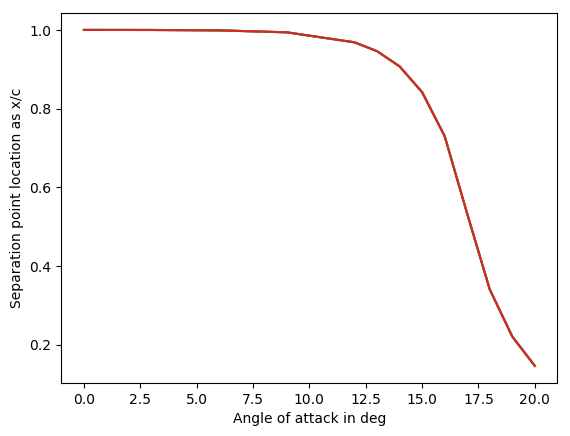

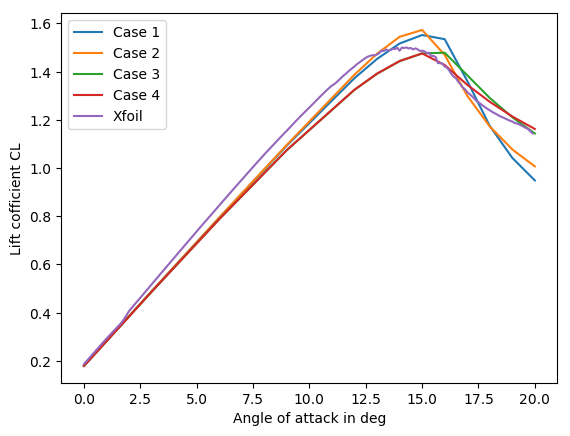

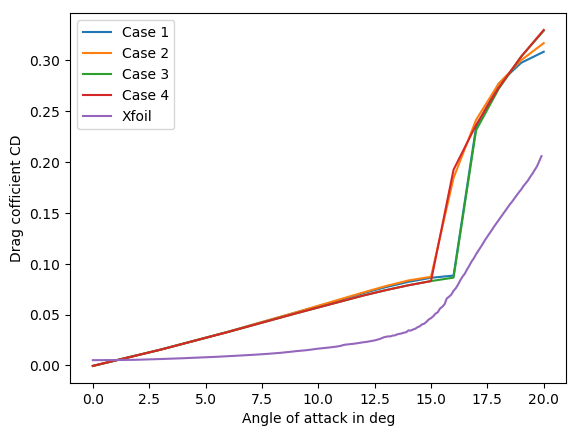

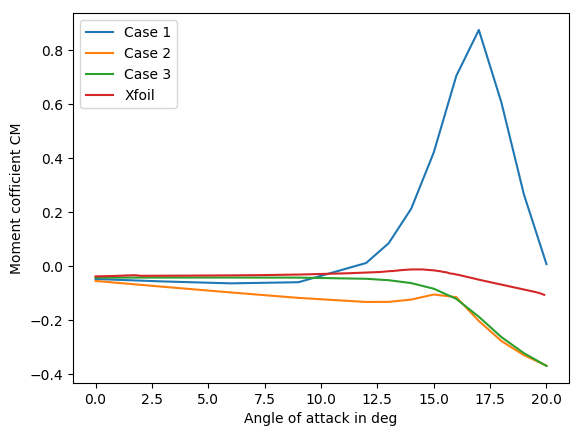

PyObject <matplotlib.legend.Legend object at 0x7f42fbad0a20>

In [9]:
sepdef1 = SeparationParams(15.05,1.71,1.92,"Sheng", k0=-0.03, k1=-0.12, k2=0.86, m=0.9)
sepdef2 = SeparationParams(14.35, 1.10, 2.32, "Original",k0=-0.07, k1 = -0.011, k2=0.07, m=1.89)

sepdef3 = SeparationParams(15.0, 3.10, 3.37, "Sheng")
sepdef4 = SeparationParams(14.1, 3.07, 3.7,"Original")


sepdef = [sepdef1 sepdef2 sepdef3 sepdef4]

nsteps = 700
aseq = [0 3 6 9 12 13 14 15 16 17 18 19 20]
no_of_cases = length(sepdef)

mat_case = zeros(nsteps,9,length(aseq),no_of_cases)

for k = 1 : no_of_cases

        for iter = 1:length(aseq)

            alphadef = ConstDef(aseq[iter]*pi/180)
            hdef = ConstDef(0.)
            udef = ConstDef(1.)#Freestream velocity is a constant. Set as constant = 1

            #The full kinematics are collected as:
            full_kinem = KinemDef(alphadef, hdef, udef)

            pvt = 0.25
            lespcrit = [5.;] #Note that the value is entered as an array. 

            # The argument "FlatPlate" provides zero camber. To use an airfoil, specify the coordinate file which should be
            #in the same folder. For eg. "sd7003.dat". 
            #The XFOIL convention must be used for the coordinate: TE->Upper surface->LE->Lower surface->TE
            surf = TwoDSurf("sd7003_fine.dat", pvt, full_kinem,lespcrit)

            curfield = TwoDFlowField()
            #Specify simulation details - time step, and number of steps.
            #The default nondimensional timestep is 0.015. There is usually no need to change this. 

            #Now the code is run as :
            #The variables mat, surf and curfield are returned
            dtstar = 0.015
        
            mat, surf, curfield = ldvm_klb(surf, curfield,sepdef[k], nsteps, dtstar)
            mat_case[:,:,iter, k]=mat        
        end
end 

# Load data from Xfoil
xfoil = Xfoil("xfoil_sd7003_CN.txt");

# Compare forces and moment coefficients

# Separation point location
for case = 1:no_of_cases
    plot(mat_case[end,2,:,1]*180./pi,mat_case[end,9,:,1], label ="Case $case")
end
xlabel("Angle of attack in deg")
ylabel("Separation point location as x/c")

#LIFT COEFFICIENT
figure()
for case =1:no_of_cases
    plot(mat_case[end,2,:,case]*180./pi,mat_case[end,6,:,case], label="Case $case")
end
plot(xfoil.alpha, xfoil.CL, label="Xfoil")
xlabel("Angle of attack in deg")
ylabel("Lift cofficient CL")
legend()

#DRAG COEFFICIENT
figure()
for case= 1:no_of_cases
    plot(mat_case[end,2,:,case]*180./pi,mat_case[end,7,:,case], label="Case $case")
end
plot(xfoil.alpha, xfoil.CD, label="Xfoil")
xlabel("Angle of attack in deg")
ylabel("Drag cofficient CD")
legend()

#DRAG COEFFICIENT
figure()
for case= 1:3
    plot(mat_case[end,2,:,case]*180./pi,mat_case[end,8,:,case], label="Case $case")
end
plot(xfoil.alpha, xfoil.CM, label="Xfoil")
xlabel("Angle of attack in deg")
ylabel("Moment cofficient CM")
legend()

## 1.2. SD7003, comparison with experiment

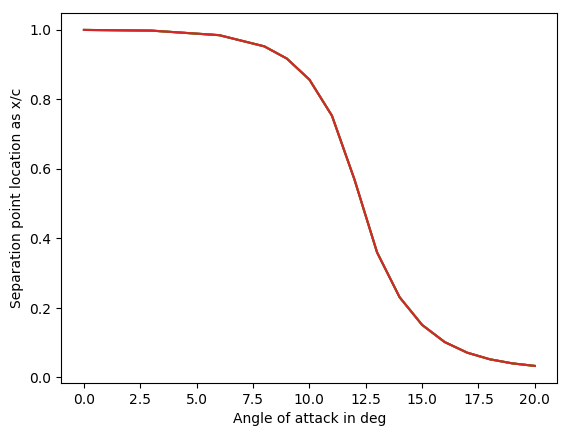

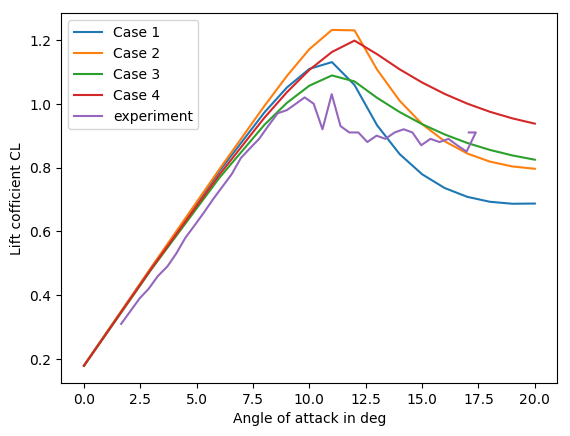

PyObject <matplotlib.legend.Legend object at 0x7f42fbf455f8>

In [10]:
sepdef1 = SeparationParams(10.6,1.71,1.92,"Sheng")
sepdef2 = SeparationParams(11.0, 1.10, 2.32, "Original")
sepdef3 = SeparationParams(10.6, 3.10, 3.37, "Sheng")
sepdef4 = SeparationParams(11.0, 3.07, 3.7,"Original")


sepdef = [sepdef1 sepdef2 sepdef3 sepdef4]

nsteps = 700
aseq = [0 3 6 8 9 10 11 12 13 14 15 16 17 18 19 20]
no_of_cases = length(sepdef)

mat_case = zeros(nsteps,9,length(aseq),no_of_cases)

for k = 1 : no_of_cases

        for iter = 1:length(aseq)

            alphadef = ConstDef(aseq[iter]*pi/180)
            hdef = ConstDef(0.)
            udef = ConstDef(1.)#Freestream velocity is a constant. Set as constant = 1

            #The full kinematics are collected as:
            full_kinem = KinemDef(alphadef, hdef, udef)

            pvt = 0.25
            lespcrit = [5.;] #Note that the value is entered as an array. 

            # The argument "FlatPlate" provides zero camber. To use an airfoil, specify the coordinate file which should be
            #in the same folder. For eg. "sd7003.dat". 
            #The XFOIL convention must be used for the coordinate: TE->Upper surface->LE->Lower surface->TE
            surf = TwoDSurf("sd7003_fine.dat", pvt, full_kinem,lespcrit)

            curfield = TwoDFlowField()
            #Specify simulation details - time step, and number of steps.
            #The default nondimensional timestep is 0.015. There is usually no need to change this. 

            #Now the code is run as :
            #The variables mat, surf and curfield are returned
            dtstar = 0.015
        
            mat, surf, curfield = ldvm_klb(surf, curfield,sepdef[k], nsteps, dtstar)
            mat_case[:,:,iter, k]=mat        
        end
end 

# Load data from Xfoil
data = readdlm("exp_sd7003_CL.txt",skipstart=1)
alpha = data[:,1]
CL = data[:,2]

# Compare forces and moment coefficients

# Separation point location
for case = 1:no_of_cases
    plot(mat_case[end,2,:,1]*180./pi,mat_case[end,9,:,1], label ="Case $case")
end
xlabel("Angle of attack in deg")
ylabel("Separation point location as x/c")

#LIFT COEFFICIENT
figure()
for case =1:no_of_cases
    plot(mat_case[end,2,:,case]*180./pi,mat_case[end,6,:,case], label="Case $case")
end
plot(alpha, CL, label="experiment")
xlabel("Angle of attack in deg")
ylabel("Lift cofficient CL")
legend()

## 2.1. NACA 0012, comparison with Xfoil

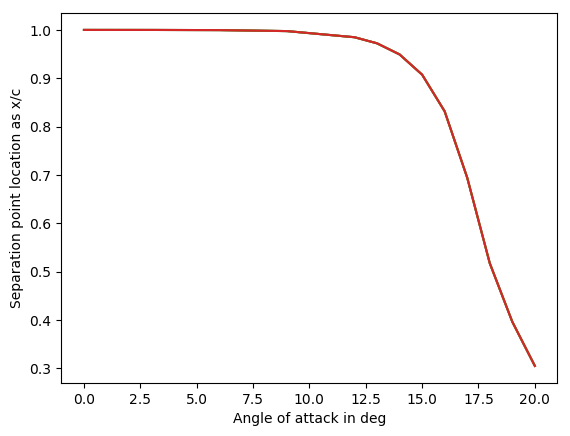

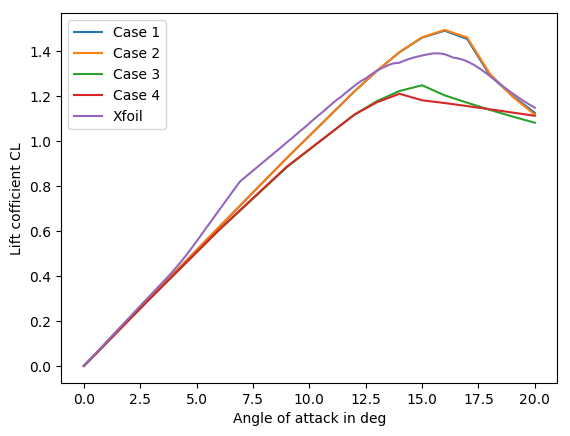

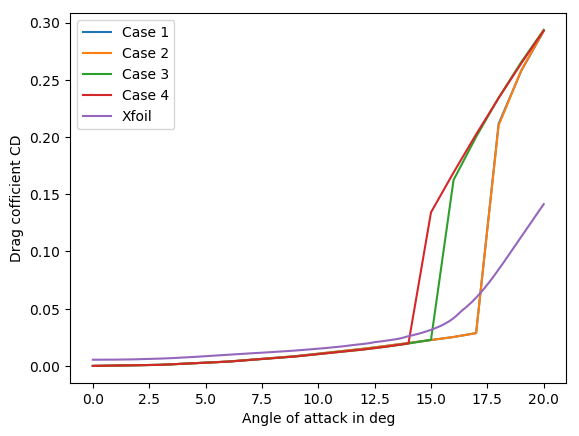

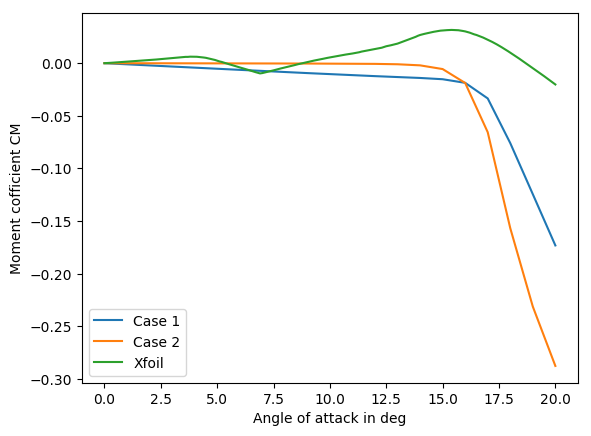

PyObject <matplotlib.legend.Legend object at 0x7f42fb7d5f98>

In [11]:
sepdef1 = SeparationParams(16.2,1.52,3.21,"Sheng", k0=-0.01, k1=-0.04, k2=0.06, m=0.9)
sepdef2 = SeparationParams(15.8, 1.52, 2.87, "Original")
sepdef3 = SeparationParams(14.5, 4.07, 4.84, "Sheng")
sepdef4 = SeparationParams(13.1, 3.66, 5.68,"Original")

sepdef = [sepdef1 sepdef2 sepdef3 sepdef4]

nsteps = 700
aseq = [0 3 6 9 12 13 14 15 16 17 18 19 20]
no_of_cases = length(sepdef)

mat_case = zeros(nsteps,9,length(aseq),no_of_cases)

for k = 1 : no_of_cases

        for iter = 1:length(aseq)

            alphadef = ConstDef(aseq[iter]*pi/180)
            hdef = ConstDef(0.)
            udef = ConstDef(1.)#Freestream velocity is a constant. Set as constant = 1

            #The full kinematics are collected as:
            full_kinem = KinemDef(alphadef, hdef, udef)

            pvt = 0.25
            lespcrit = [5.;] #Note that the value is entered as an array. 

            # The argument "FlatPlate" provides zero camber. To use an airfoil, specify the coordinate file which should be
            #in the same folder. For eg. "sd7003.dat". 
            #The XFOIL convention must be used for the coordinate: TE->Upper surface->LE->Lower surface->TE
            surf = TwoDSurf("n0012.dat", pvt, full_kinem,lespcrit)

            curfield = TwoDFlowField()
            #Specify simulation details - time step, and number of steps.
            #The default nondimensional timestep is 0.015. There is usually no need to change this. 

            #Now the code is run as :
            #The variables mat, surf and curfield are returned
            dtstar = 0.015
        
            mat, surf, curfield = ldvm_klb(surf, curfield,sepdef[k], nsteps, dtstar)
            mat_case[:,:,iter, k]=mat        
        end
end 

# Load data from Xfoil
xfoil = Xfoil("xfoil_0012_CN.txt");

# Compare forces and moment coefficients

# Separation point location
for case = 1:no_of_cases
    plot(mat_case[end,2,:,1]*180./pi,mat_case[end,9,:,1], label ="Case $case")
end
xlabel("Angle of attack in deg")
ylabel("Separation point location as x/c")

#LIFT COEFFICIENT
figure()
for case =1:no_of_cases
    plot(mat_case[end,2,:,case]*180./pi,mat_case[end,6,:,case], label="Case $case")
end
plot(xfoil.alpha, xfoil.CL, label="Xfoil")
xlabel("Angle of attack in deg")
ylabel("Lift cofficient CL")
legend()

#DRAG COEFFICIENT
figure()
for case= 1:no_of_cases
    plot(mat_case[end,2,:,case]*180./pi,mat_case[end,7,:,case], label="Case $case")
end
plot(xfoil.alpha, xfoil.CD, label="Xfoil")
xlabel("Angle of attack in deg")
ylabel("Drag cofficient CD")
legend()

#MOMENT COEFFICIENT
figure()
for case= 1:2
    plot(mat_case[end,2,:,case]*180./pi,mat_case[end,8,:,case], label="Case $case")
end
plot(xfoil.alpha, xfoil.CM, label="Xfoil")
xlabel("Angle of attack in deg")
ylabel("Moment cofficient CM")
legend()

## 2.2. NACA 0012, comparison with experiment [2]

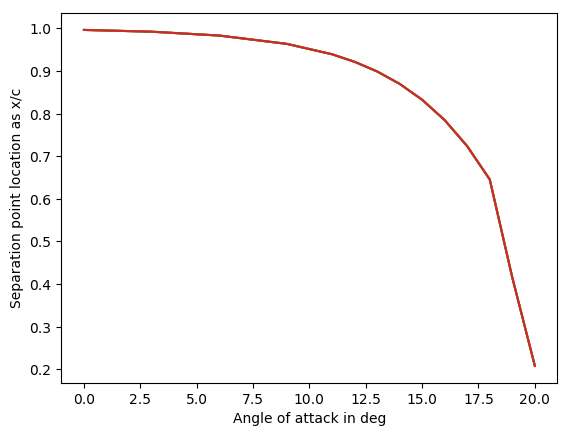

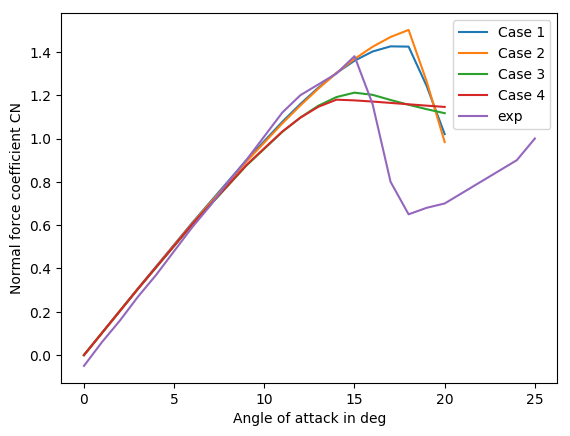

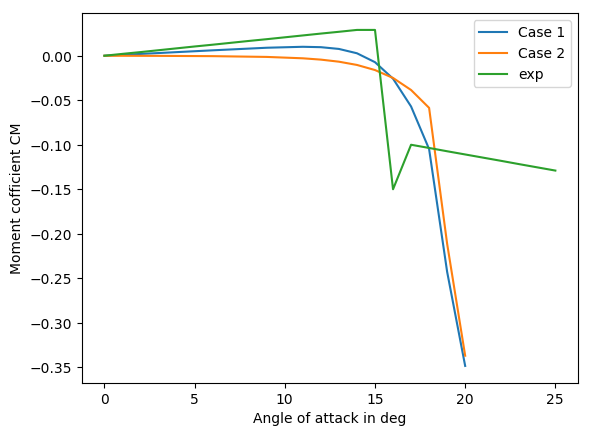

PyObject <matplotlib.legend.Legend object at 0x7f42fba6a390>

In [12]:
sepdef1 = SeparationParams(17.13,3.62,1.20,"Sheng", k0=0.01, k1=-0.17, k2=0.04, m=2.56)
sepdef2 = SeparationParams(17.13, 4.86, 0.89, "Original")
sepdef3 = SeparationParams(14.5, 4.07, 4.84, "Sheng")
sepdef4 = SeparationParams(13.1, 3.66, 5.68,"Original")

sepdef = [sepdef1 sepdef2 sepdef3 sepdef4]

nsteps = 700
aseq = [0 3 6 9 11 12 13 14 15 16 17 18 19 20]
no_of_cases = length(sepdef)

mat_case = zeros(nsteps,9,length(aseq),no_of_cases)

for k = 1 : no_of_cases

        for iter = 1:length(aseq)

            alphadef = ConstDef(aseq[iter]*pi/180)
            hdef = ConstDef(0.)
            udef = ConstDef(1.)#Freestream velocity is a constant. Set as constant = 1

            #The full kinematics are collected as:
            full_kinem = KinemDef(alphadef, hdef, udef)

            pvt = 0.25
            lespcrit = [5.;] #Note that the value is entered as an array. 

            # The argument "FlatPlate" provides zero camber. To use an airfoil, specify the coordinate file which should be
            #in the same folder. For eg. "sd7003.dat". 
            #The XFOIL convention must be used for the coordinate: TE->Upper surface->LE->Lower surface->TE
            surf = TwoDSurf("n0012.dat", pvt, full_kinem,lespcrit)

            curfield = TwoDFlowField()
            #Specify simulation details - time step, and number of steps.
            #The default nondimensional timestep is 0.015. There is usually no need to change this. 

            #Now the code is run as :
            #The variables mat, surf and curfield are returned
            dtstar = 0.015
        
            mat, surf, curfield = ldvm_klb(surf, curfield,sepdef[k], nsteps, dtstar)
            mat_case[:,:,iter, k]=mat        
        end
end 

# Load data from Xfoil
data = readdlm("exp_0012_CN.txt",skipstart=1)
alpha = data[:,1]
CN = data[:,2]
CM = data[:,3]

# Compare forces and moment coefficients

# Separation point location
for case = 1:no_of_cases
    plot(mat_case[end,2,:,1]*180./pi,mat_case[end,9,:,1], label ="Case $case")
end
xlabel("Angle of attack in deg")
ylabel("Separation point location as x/c")

#NORMAL FORCE COEFFICIENT
figure()
for case =1:no_of_cases
    plot(mat_case[end,2,:,case]*180./pi,mat_case[end,6,:,case].*cos(mat_case[end,2,:,case]).+mat_case[end,7,:,case].*sin(mat_case[end,2,:,case]), label="Case $case")
end
plot(alpha, CN, label="exp")
xlabel("Angle of attack in deg")
ylabel("Normal force coefficient CN")
legend()

#MOMENT COEFFICIENT
figure()
for case= 1:2
    plot(mat_case[end,2,:,case]*180./pi,mat_case[end,8,:,case], label="Case $case")
end
plot(alpha, CM, label="exp")
xlabel("Angle of attack in deg")
ylabel("Moment cofficient CM")
legend()

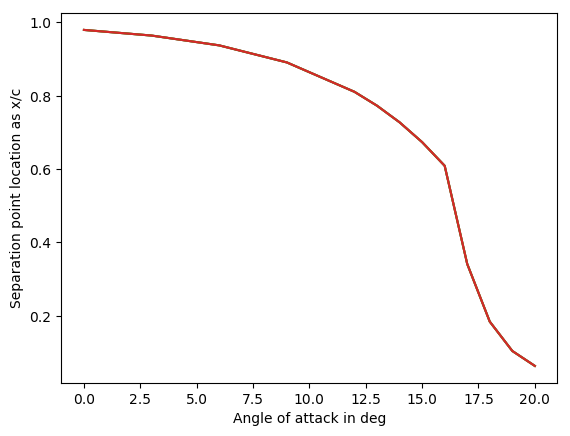

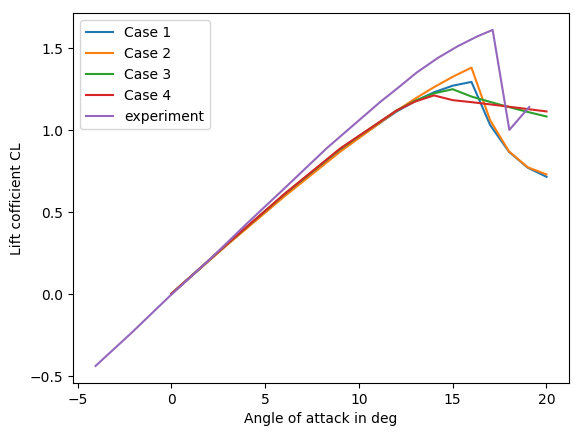

PyObject <matplotlib.legend.Legend object at 0x7f42fb6fb588>

In [13]:
sepdef1 = SeparationParams(15.0,5.05,1.34,"Sheng")
sepdef2 = SeparationParams(15.0, 7.56, 1.12, "Original")

sepdef = [sepdef1 sepdef2 sepdef3 sepdef4]

nsteps = 700
aseq = [0 3 6 9 12 13 14 15 16 17 18 19 20]
no_of_cases = length(sepdef)

mat_case = zeros(nsteps,9,length(aseq),no_of_cases)

for k = 1 : no_of_cases

        for iter = 1:length(aseq)

            alphadef = ConstDef(aseq[iter]*pi/180)
            hdef = ConstDef(0.)
            udef = ConstDef(1.)#Freestream velocity is a constant. Set as constant = 1

            #The full kinematics are collected as:
            full_kinem = KinemDef(alphadef, hdef, udef)

            pvt = 0.25
            lespcrit = [5.;] #Note that the value is entered as an array. 

            # The argument "FlatPlate" provides zero camber. To use an airfoil, specify the coordinate file which should be
            #in the same folder. For eg. "sd7003.dat". 
            #The XFOIL convention must be used for the coordinate: TE->Upper surface->LE->Lower surface->TE
            surf = TwoDSurf("n0012.dat", pvt, full_kinem,lespcrit)

            curfield = TwoDFlowField()
            #Specify simulation details - time step, and number of steps.
            #The default nondimensional timestep is 0.015. There is usually no need to change this. 

            #Now the code is run as :
            #The variables mat, surf and curfield are returned
            dtstar = 0.015
        
            mat, surf, curfield = ldvm_klb(surf, curfield,sepdef[k], nsteps, dtstar)
            mat_case[:,:,iter, k]=mat        
        end
end 

# Load data from Xfoil
data = readdlm("exp_0012_CL.txt",skipstart=1)
alpha = data[:,1]
CL = data[:,2]

# Compare forces and moment coefficients

# Separation point location
for case = 1:no_of_cases
    plot(mat_case[end,2,:,1]*180./pi,mat_case[end,9,:,1], label ="Case $case")
end
xlabel("Angle of attack in deg")
ylabel("Separation point location as x/c")

#LIFT COEFFICIENT
figure()
for case =1:no_of_cases
    plot(mat_case[end,2,:,case]*180./pi,mat_case[end,6,:,case], label="Case $case")
end
plot(alpha, CL, label="experiment")
xlabel("Angle of attack in deg")
ylabel("Lift cofficient CL")
legend()

## 3.1. NACA 0015, comparison with Xfoil

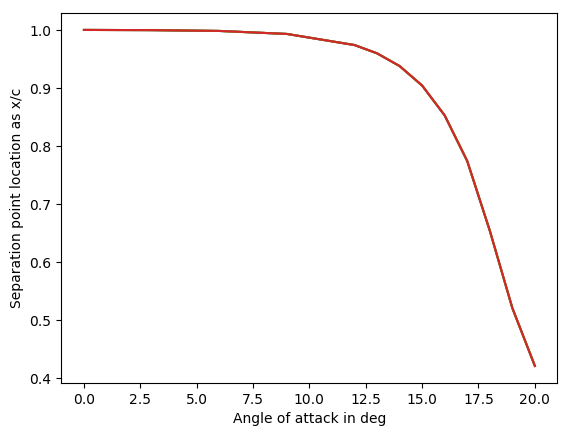

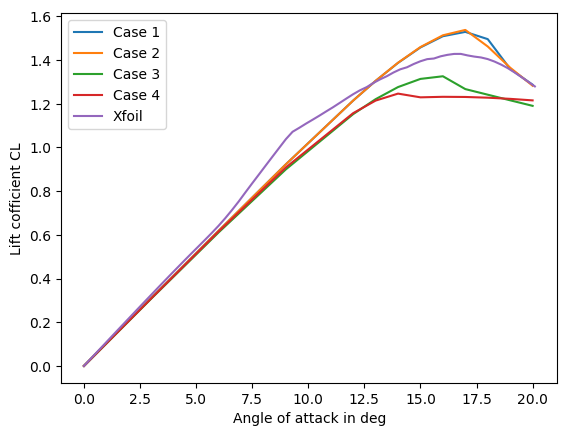

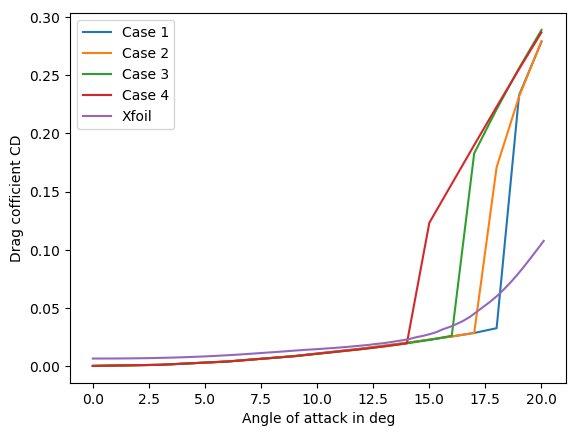

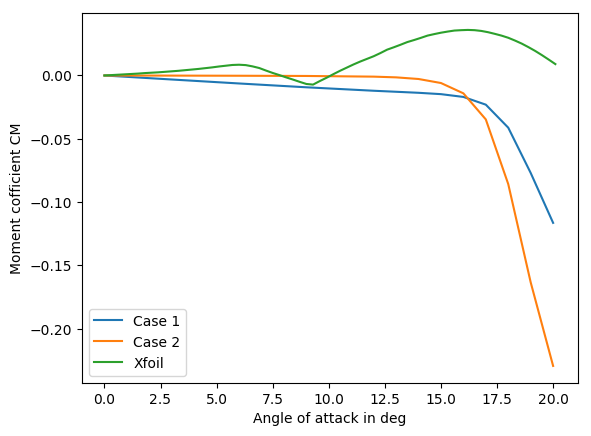

PyObject <matplotlib.legend.Legend object at 0x7f42fbeb9e10>

In [14]:
sepdef1 = SeparationParams(17.0, 2.12,4.00,"Sheng", k0=-0.01, k1=-0.01, k2=0.046, m=1.00)
sepdef2 = SeparationParams(16.5, 2.17, 3.54, "Original")
sepdef3 = SeparationParams(15.3, 3.52, 5.65, "Sheng")
sepdef4 = SeparationParams(13.5, 2.45, 7.13,"Original")

sepdef = [sepdef1 sepdef2 sepdef3 sepdef4]

nsteps = 700
aseq = [0 3 6 9 12 13 14 15 16 17 18 19 20]
no_of_cases = length(sepdef)

mat_case = zeros(nsteps,9,length(aseq),no_of_cases)

for k = 1 : no_of_cases

        for iter = 1:length(aseq)

            alphadef = ConstDef(aseq[iter]*pi/180)
            hdef = ConstDef(0.)
            udef = ConstDef(1.)#Freestream velocity is a constant. Set as constant = 1

            #The full kinematics are collected as:
            full_kinem = KinemDef(alphadef, hdef, udef)

            pvt = 0.25
            lespcrit = [5.;] #Note that the value is entered as an array. 

            # The argument "FlatPlate" provides zero camber. To use an airfoil, specify the coordinate file which should be
            #in the same folder. For eg. "sd7003.dat". 
            #The XFOIL convention must be used for the coordinate: TE->Upper surface->LE->Lower surface->TE
            surf = TwoDSurf("naca0015.dat", pvt, full_kinem,lespcrit)

            curfield = TwoDFlowField()
            #Specify simulation details - time step, and number of steps.
            #The default nondimensional timestep is 0.015. There is usually no need to change this. 

            #Now the code is run as :
            #The variables mat, surf and curfield are returned
            dtstar = 0.015
        
            mat, surf, curfield = ldvm_klb(surf, curfield,sepdef[k], nsteps, dtstar)
            mat_case[:,:,iter, k]=mat        
        end
end 

# Load data from Xfoil
xfoil = Xfoil("xfoil_0015_CN.txt");

# Compare forces and moment coefficients

# Separation point location
for case = 1:no_of_cases
    plot(mat_case[end,2,:,1]*180./pi,mat_case[end,9,:,1], label ="Case $case")
end
xlabel("Angle of attack in deg")
ylabel("Separation point location as x/c")

#LIFT COEFFICIENT
figure()
for case =1:no_of_cases
    plot(mat_case[end,2,:,case]*180./pi,mat_case[end,6,:,case], label="Case $case")
end
plot(xfoil.alpha, xfoil.CL, label="Xfoil")
xlabel("Angle of attack in deg")
ylabel("Lift cofficient CL")
legend()

#DRAG COEFFICIENT
figure()
for case= 1:no_of_cases
    plot(mat_case[end,2,:,case]*180./pi,mat_case[end,7,:,case], label="Case $case")
end
plot(xfoil.alpha, xfoil.CD, label="Xfoil")
xlabel("Angle of attack in deg")
ylabel("Drag cofficient CD")
legend()

#MOMENT COEFFICIENT
figure()
for case= 1:2
    plot(mat_case[end,2,:,case]*180./pi,mat_case[end,8,:,case], label="Case $case")
end
plot(xfoil.alpha, xfoil.CM, label="Xfoil")
xlabel("Angle of attack in deg")
ylabel("Moment cofficient CM")
legend()